# How does PICA affect the position of the urgent nodes in the attack graphs?

### Imports

In [10]:
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pygraphviz # Needs to be imported for some networkx functions
from enum import Enum
import math
import pandas as pd
import numpy as np

### Mappings

In [11]:
class MicroAttackStageConfidentiality(Enum):
    INIT = 0.1

    # Low Severity
    TARGET_IDEN = 0.1
    SURFING = 0.1
    SOCIAL_ENGINEERING = 0.25
    HOST_DISC = 0.25
    SERVICE_DISC = 0.25
    VULN_DISC = 0.25
    INFO_DISC = 0.25

    # Medium Severity
    USER_PRIV_ESC = 0.5
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.5
    BRUTE_FORCE_CREDS = 0.5
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.5
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.5
    SPEARPHISHING = 0.5
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.1
    COMMAND_AND_CONTROL = 0.5
    LATERAL_MOVEMENT = 0.5
    ARBITRARY_CODE_EXE = 0.5
    PRIV_ESC = 0.5

    # High Severity
    END_POINT_DOS = 0.1
    NETWORK_DOS = 0.1
    SERVICE_STOP = 0.1
    RESOURCE_HIJACKING = 0.1
    DATA_DESTRUCTION = 0.1
    CONTENT_WIPE = 0.1
    DATA_ENCRYPTION = 0.1
    DEFACEMENT = 1
    DATA_MANIPULATION = 0.1
    DATA_EXFILTRATION = 1
    DATA_DELIVERY = 0.1
    PHISHING = 1


class MicroAttackStageAvailability(Enum):
    INIT = 0.1

    # Low Severity
    TARGET_IDEN = 0.1
    SURFING = 0.1
    SOCIAL_ENGINEERING = 0.1
    HOST_DISC = 0.1
    SERVICE_DISC = 0.1
    VULN_DISC = 0.1
    INFO_DISC = 0.1

    # Medium Severity
    USER_PRIV_ESC = 0.5
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.1
    BRUTE_FORCE_CREDS = 0.5
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.1
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.1
    SPEARPHISHING = 0.1
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.1
    COMMAND_AND_CONTROL = 0.1
    LATERAL_MOVEMENT = 0.1
    ARBITRARY_CODE_EXE = 0.1
    PRIV_ESC = 0.1

    # High Severity
    END_POINT_DOS = 1
    NETWORK_DOS = 1
    SERVICE_STOP = 1
    RESOURCE_HIJACKING = 1
    DATA_DESTRUCTION = 1
    CONTENT_WIPE = 1
    DATA_ENCRYPTION = 1
    DEFACEMENT = 0.1
    DATA_MANIPULATION = 0.1
    DATA_EXFILTRATION = 0.1
    DATA_DELIVERY = 0.1
    PHISHING = 0.1

    NON_MALICIOUS = 0.1


class MicroAttackStageIntegrity(Enum):
    INIT = 0.1

    # Low Severity
    TARGET_IDEN = 0.1
    SURFING = 0.1
    SOCIAL_ENGINEERING = 0.1
    HOST_DISC = 0.1
    SERVICE_DISC = 0.1
    VULN_DISC = 0.25
    INFO_DISC = 0.1

    # Medium Severity
    USER_PRIV_ESC = 0.1
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.1
    BRUTE_FORCE_CREDS = 0.1
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.5
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.5
    SPEARPHISHING = 0.1
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.1
    COMMAND_AND_CONTROL = 0.5
    LATERAL_MOVEMENT = 0.5
    ARBITRARY_CODE_EXE = 0.5
    PRIV_ESC = 0.1

    # High Severity
    END_POINT_DOS = 0.1
    NETWORK_DOS = 0.1
    SERVICE_STOP = 0.1
    RESOURCE_HIJACKING = 0.1
    DATA_DESTRUCTION = 1
    CONTENT_WIPE = 1
    DATA_ENCRYPTION = 1
    DEFACEMENT = 1
    DATA_MANIPULATION = 1
    DATA_EXFILTRATION = 0.1
    DATA_DELIVERY = 1
    PHISHING = 0.1

    NON_MALICIOUS = 0.1


# AIF Mapping
verbose_micro = {'INIT': 'INITILIZE',
'TARGET_IDEN': 'TARGET IDENTIFICATION',
'SURFING': 'SURFING',
'SOCIAL_ENGINEERING': 'SOCIAL ENGINEERING',
'HOST_DISC': 'HOST DISCOVERY',
'SERVICE_DISC': 'SERVICE DISCOVERY',
'VULN_DISC': 'VULNERABILTY DISCOVERY',
'INFO_DISC': 'INFO DISCOVERY',
'USER_PRIV_ESC': 'USER PRIVILEGE ESCALATION',
'ROOT_PRIV_ESC': 'ROOT PRIVILEGE ESCALATION',
'NETWORK_SNIFFING': 'NETWORK SNIFFING',
'BRUTE_FORCE_CREDS': 'BRUTE FORCE CREDENTIALS',
'ACCT_MANIP': 'ACCOUNT MANIPULATION',
'TRUSTED_ORG_EXP': 'TRUSTED ORG. EXPLOIT',
'PUBLIC_APP_EXP': 'PUBLIC APP EXPLOIT',
'REMOTE_SERVICE_EXP': 'REMOTE SERVICE EXPLOIT',
'SPEARPHISHING': 'SPEAR PHISHING',
'SERVICE_SPECIFIC': 'SERVICE SPECIFIC',
'DEFENSE_EVASION': 'DEFENSE EVASION',
'COMMAND_AND_CONTROL': 'COMMAND AND CONTROL',
'LATERAL_MOVEMENT': 'LATERAL MOVEMENT',
'ARBITRARY_CODE_EXE': 'ARBITRARY CODE EXECUTION',
'PRIV_ESC': 'PRIVILEGE ESCALATION',
'END_POINT_DOS': 'END POINT DoS',
'NETWORK_DOS': 'NETWORK DoS',
'SERVICE_STOP': 'SERVICE STOP',
'RESOURCE_HIJACKING': 'RESOURCE HIJACKING',
'DATA_DESTRUCTION': 'DATA DESTRUCTION',
'CONTENT_WIPE': 'CONTENT WIPE',
'DATA_ENCRYPTION': 'DATA ENCRYPTION',
'DEFACEMENT': 'DEFACEMENT',
'DATA_MANIPULATION': 'DATA MANIPULATION',
'DATA_EXFILTRATION': 'DATA EXFILTRATION',
'DATA_DELIVERY': 'DATA DELIVERY',
'PHISHING': 'PHISHING',
'NON_MALICIOUS': 'NOT MALICIOUS'}

inverted_mapping = {v: k for k,v in verbose_micro.items()}

### Helper Methods

In [12]:
def print_sorted_dic(dic):
    """
    Print the given dictionary (key, score) sorted on the score.
    """
    arr = sorted(dic.items(), key= lambda x : -x[1])
    for i,el in enumerate(arr):
        print(i+1,el)

def get_urgency_ais(urgency, level="HIGH"):
    res = []

    if level == "HIGH":
        for aif,urgence in urgency.items():
            if urgence > .5:
                res.append(aif)
        return res
    elif level == "MED":
        for aif,urgence in urgency.items():
            if .5 >= urgence > .25:
                res.append(aif)
        return res

    elif level == "LOW":
        for aif,urgence in urgency.items():
            if urgence <= .25:
                res.append(aif)

        return res
    else:
        raise Exception("Wrong level provided")

def get_attack_stage(node):
    index = 1 if "Victim" in node else 0
    
    name = node.split("\n")[index].replace('"',"").replace("\r","")
    name = inverted_mapping[name]
    return name
    
def get_as_occurences(graph):
    aif_count = dict()

    # Count AS occurences
    for node in graph.nodes:
        # Get attack stage and count
        name = get_attack_stage(node)
        aif_count[name] = aif_count.get(name, 0) + 1
    
    return aif_count



def distance_to_closest_root(dist, node):
    return dist[node]
    
def get_urgency_scores(urgency, level="HIGH"):
    res = {}

    if level == "HIGH":
        for aif,urgence in urgency.items():
            if urgence > .5:
                res[aif] = urgence
        return res
    elif level == "MED":
        for aif,urgence in urgency.items():
            if .5 >= urgence > .25:
                res[aif] = urgence
        return res

    elif level == "LOW":
        for aif,urgence in urgency.items():
            if urgence <= .25:
                res[aif] = urgence

        return res
    else:
        raise Exception("Wrong level provided")
    
def box_plot_in_going_edges(graph, split):
    
    split_deg = dict()
        
    for level, nodes in split.items():
        in_degs = []
        for node in nodes:
            in_degs.append(len(graph.in_edges(node)))
        
        split_deg[level] = in_degs
       
    data = pd.DataFrame.from_dict(split_deg, orient='index').T
    plt.figure()
    
    chart = sns.boxplot(data=data)
    chart.set_xlabel('Urgency Level')
    chart.set_ylabel('Number of in-going edges')
    plt.show()
    
def box_plot_dist_to_root(dist, split, title, graph_name, metric_name):
    
    split_deg = dict()
    
    for level, nodes in split.items():
        in_degs = []
        for node in nodes:
            in_degs.append(distance_to_closest_root(dist, node))
        
        split_deg[level] = in_degs
    
    print(split_deg["Low Urgency"])
    
    data = pd.DataFrame.from_dict(split_deg, orient='index').T
    plt.figure()
    
    chart = sns.violinplot(data=data)
    
    chart.set_xlabel('Urgency ranking')
    chart.set_ylabel('Distance to closest root')
    chart.set_title(title)
    plt.savefig("./figs/rq2/" + graph_name + "/root_violin" + graph_name + "_" + str(metric_name) + ".pdf")
    plt.show()
    
def box_plot_dist_to_start(dist, split, title, graph_name, metric_name):
    
    split_deg = dict()
    
    for level, nodes in split.items():
        in_degs = []
        for node in nodes:
            in_degs.append(distance_to_closest_start(dist, node))
        
        split_deg[level] = in_degs
       
    print(split_deg["Low Urgency"])
    
    data = pd.DataFrame.from_dict(split_deg, orient='index').T
    plt.figure()
    
    chart = sns.violinplot(data=data)
    
    chart.set_xlabel('Urgency ranking')
    chart.set_ylabel('Distance to closest start')
    chart.set_title(title)
    plt.savefig("./figs/rq2/" + graph_name + "/start_violin" + graph_name + "_" + str(metric_name) + ".pdf")
    plt.show()
    

def distance_to_closest_start(dist, node):
        return dist[node]

In [13]:
def get_paths(dataset):
    file_path = "./paths/" + dataset + "paths.txt"
    result = []
    
    with open(file_path, 'r') as file:
        content = file.read()
    
    splits = content.split("-----------\n")
#     print(splits[1::])
    for split in splits[1::]:
        split_result = []
        edges = split.split("--- \n")[:-1]
        prev_end = None
        
        # Even number of edges
        if len(edges) % 2 == 0:
            # Take first node and then take every odd edge
            for index, line in enumerate(edges):
                if index == 0:
                    split_result.append(line.split("->")[0].strip())
                
                if index % 2 != 1 or line == "": continue

                split_result.append(line.split("->")[0].strip())
                split_result.append(line.split("->")[1].strip())
        # Odd number of edges
        else:
            # Take every even edge
            for index, line in enumerate(edges):
                if index % 2 != 0 or line == "": continue

                split_result.append(line.split("->")[0].strip())
                split_result.append(line.split("->")[1].strip())
        
#         print("PATH", split_result)
        result.append(split_result)
    
    return result


In [14]:
def calculate_distances(dataset):
    start_dist = dict()
    end_dist = dict()
    
    path_array = get_paths(dataset)
    
    for path in path_array:
        for position, node in enumerate(path):
            start_dist[node] = min(start_dist.get(node, math.inf), position)
            end_dist[node] = min(end_dist.get(node, math.inf), len(path)-position)
    
    return start_dist, end_dist
    

[2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16

<Figure size 432x288 with 0 Axes>

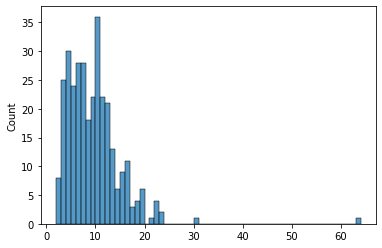

<Figure size 432x288 with 0 Axes>

In [15]:
final_array = get_paths("2018")
lengths = [len(path) for path in final_array]

print(sorted(lengths))

sns.histplot(lengths, binwidth=1)
plt.figure()
# sns.histplot(start_dist.values())
# plt.figure()
# sns.histplot(end_dist.values())


### Metrics

#### PICA

In [16]:
def get_pica_nodes(graph, w1, w2, w3):
    urgence = dict()
    max_in = 0

#     aif_count = dict()

#     for node in graph.nodes:
#         if "Victim" in node:
#             continue

#         name = get_attack_stage(node)
#         aif_count[name] = aif_count.get(name, 0) + 1

    for node in graph.nodes:
        if "Victim" in node:
            continue

        max_in = max(max_in, len(graph.in_edges(node)))

        non_verbose = get_attack_stage(node)

        urgence[node] = get_cia(non_verbose, w1, w2, w3)

    # Multiply by in-degree factor
    for node in graph.nodes:
        if "Victim" in node:
            continue
        if len(graph.in_edges(node)) == 0:
            urgence[node] = 1/max_in * urgence[node]
        else:
            urgence[node] = len(graph.in_edges(node))/max_in * urgence[node]


    # Normalise to [0,1]
    max_urgence = max(urgence.values())
    min_urgence = min(urgence.values())
    for node in graph.nodes:
        if "Victim" in node:
            continue

        urgence[node] = (urgence[node]-min_urgence)/(max_urgence-min_urgence)
#     print_sorted_dic(urgence)
    return urgence

def get_cia(ais, w1, w2, w3):
    confidentiality = MicroAttackStageConfidentiality.__getitem__(ais).value
    availability = MicroAttackStageAvailability.__getitem__(ais).value
    integrity = MicroAttackStageIntegrity.__getitem__(ais).value
    
    return (w1 * confidentiality + w2 * integrity + w3 * availability)/(w1+w2+w3)

def get_pica(graph, w1, w2, w3, percentage):
    return node_to_aif(get_pica_nodes(graph, w1, w2, w3), percentage)

def node_to_aif(urgence, percentage):
    aif_urgence = get_ais_nodes(urgence)

    aif_avg_urg = dict()

    # For each AS, take the average of the highest X percentage
    for aif,nodes in aif_urgence.items():
        if nodes is None:
            continue
        sorted_dict = sorted(nodes, reverse=True)

        # Determine the number of items to include in the top X% based on the dictionary size
        top_25_percent_count = math.ceil(len(sorted_dict) * percentage)

        top_25_percent_dict = sorted_dict[:top_25_percent_count]
        #
        aif_avg_urg[aif] = sum(top_25_percent_dict)/len(top_25_percent_dict)

    return aif_avg_urg

def get_ais_nodes(node_urgency):
    aif_urgency = dict()
    
    for node, urgency in node_urgency.items():
        name = get_attack_stage(node)

        if aif_urgency.get(name) is None:
            aif_urgency[name] = [urgency]
        else:
            aif_urgency.get(name).append(urgency)
    
    return aif_urgency

def execute_pica_percentages(graph, percentages):
    urgencies = []

    for percentage in percentages:
        urgencies.append(get_pica(graph, 1, 1, 1, percentage))

    return urgencies

### Graph Selection

In [17]:
gr_2018 = nx.nx_agraph.read_dot("./2018AGs/combined/combined-2018.dot")
gr_2017 = nx.nx_agraph.read_dot("./2017AGs/combined/combined-2017.dot")

graphs = [gr_2017, gr_2018]
graph_names = ["gr_2017", "gr_2018"]

In [27]:
# Graph selection for experiment
final = gr_2018
start_dist, end_dist = calculate_distances("2018")
paths = get_paths("2018")

In [28]:
s = set()
for path in paths:
#     print(final.nodes[path[0]]["fillcolor"])
    s.add(path[0])

print(len(s))

count = 0

for value in start_dist.values():
    if value == 0: count = count + 1
print(count)

24
24


In [29]:
temp3 = []
for element in final.nodes:
    if element not in start_dist.keys():
        if "Victim" in element:
            continue
        temp3.append(element)
print(temp3)

print(len(start_dist.keys()))
print(len(end_dist.keys()))

[]
172
172


In [30]:
for key in start_dist.keys():
    if not final.has_node(key):
        print(key)
        print("")

### Quantitative

In [31]:
pica_node_urgency = get_pica_nodes(final, 1, 1, 1)

In [32]:
# Print number of high/med/low urgency AIS for baseline
pica_high = get_urgency_ais(pica_node_urgency, "HIGH")
pica_med = get_urgency_ais(pica_node_urgency, "MED")
pica_low = get_urgency_ais(pica_node_urgency, "LOW")

pica_split = {"High Urgency": pica_high, "Medium Urgency": pica_med, "Low Urgency": pica_low}

# print(len(pica_high), pica_high)
# print(len(pica_med), pica_med)
# print(len(pica_low), pica_low)

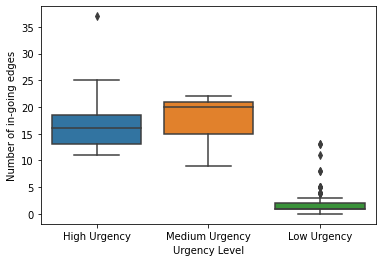

1.9741935483870967


In [33]:
# def get_root_distance_variance(graph, urgency, level="HIGH"):
#     urgency = np.array([distance_to_closest_root(graph, node) for node,urgence in urgency.items() if urgence > 0.5])
#     if debug: print("root_dists", urgency)
#     return urgency, np.var(urgency)

# def get_indeg_variance(graph, urgency, level="HIGH")
# print(get_indeg_variance(final, pica_high))
box_plot_in_going_edges(final, pica_split)

dd = []

for node in pica_split["Low Urgency"]:
    dd.append(len(final.in_edges(node)))
    
print(np.average(dd))
    
# graph_ingoing_edges(final, pica_high, "In-going edges high urgency nodes PICA 2018")
# print(get_indeg_variance(final, pica_med))
# graph_ingoing_edges(final, pica_med, "In-going edges med urgency nodes PICA 2018")
# print(get_indeg_variance(final, pica_low))
# graph_ingoing_edges(final, pica_low, "In-going edges low urgency nodes PICA 2018")

[1, 2, 3, 2, 2, 3, 4, 2, 3, 3, 3, 4, 4, 3, 4, 3, 2, 2, 7, 2, 3, 2, 3, 1, 3, 3, 2, 2, 2, 8, 2, 2, 2, 2, 2, 4, 2, 6, 4, 3, 2, 4, 3, 3, 1, 3, 1, 3, 2, 2, 1, 3, 2, 6, 9, 3, 3, 8, 3, 1, 4, 1, 1, 5, 3, 2, 2, 2, 1, 8, 2, 1, 3, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 3, 3, 3, 2, 2, 3, 3, 2, 5, 2, 1, 3, 2, 1, 2, 3, 1, 3, 2, 1, 3, 2, 1, 1, 2, 1, 3, 1, 3, 2, 1, 3, 2, 1, 2, 1, 2, 1, 1, 1, 3, 3, 2, 2, 2, 1, 7, 2, 1, 1, 4, 3, 2, 1, 3, 2, 1, 2, 2, 1, 1, 3, 2, 1, 5, 3, 2, 1, 1, 1, 4, 1]


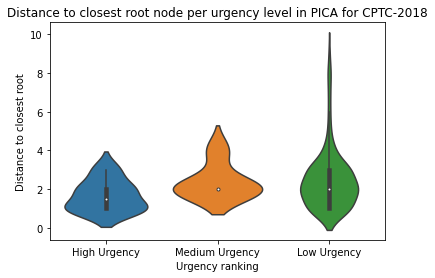

In [34]:
# def graph_dist_to_root(graph, urgency, title):
# def box_plot_dist_to_root(graph, split, title):

box_plot_dist_to_root(end_dist, pica_split, "Distance to closest root node per urgency level in PICA for CPTC-2018", "2018", "PICA")
# print(get_indeg_variance(final, base_high))
# graph_dist_to_root(final, pica_high, "Distance to closest root for high urgency nodes PICA 2018")
# print(get_indeg_variance(final, base_med))
# graph_dist_to_root(final, pica_med, "Distance to closest root for med urgency nodes PICA 2018")
# print(get_indeg_variance(final, base_low))
# graph_dist_to_root(final, pica_low, "Distance to closest root for low urgency nodes PICA 2018")

[10, 0, 7, 0, 0, 1, 1, 0, 1, 1, 4, 0, 1, 1, 2, 1, 1, 1, 3, 1, 6, 7, 1, 2, 1, 18, 7, 4, 9, 32, 62, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 3, 7, 1, 8, 9, 5, 1, 8, 9, 11, 16, 0, 0, 16, 0, 0, 0, 0, 2, 1, 1, 1, 13, 9, 15, 9, 10, 1, 17, 10, 11, 2, 13, 12, 1, 0, 2, 3, 16, 3, 0, 4, 1, 5, 6, 8, 16, 3, 4, 11, 2, 6, 7, 5, 9, 19, 4, 22, 13, 17, 18, 19, 20, 21, 15, 7, 11, 5, 8, 9, 10, 11, 12, 13, 14, 7, 7, 6, 10, 15, 14, 9, 12, 13, 13, 10, 14, 1, 6, 4, 7, 0, 1, 2, 3, 4, 5, 6, 16, 12, 17, 14, 0, 5, 4, 9, 16, 17, 18, 13, 3, 10, 2]


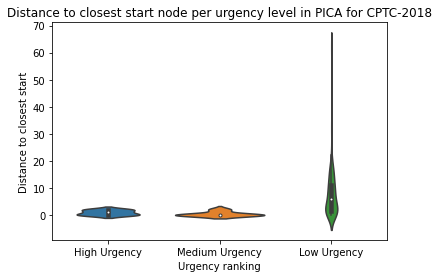

In [35]:
box_plot_dist_to_start(start_dist, pica_split, "Distance to closest start node per urgency level in PICA for CPTC-2018", "2018", "PICA")


In [20]:
for node in final.nodes:
    if "Victim" in node: continue
    if pica_node_urgency[node] > .5:
        final.nodes[node]["fontcolor"] = 'firebrick4'
    elif 0.25 < pica_node_urgency[node] <= .5:
        final.nodes[node]["fontcolor"] = 'darkgoldenrod1'
    elif pica_node_urgency[node] <= .25:
        final.nodes[node]["fontcolor"] = 'chartreuse'
    final.nodes[node].pop("tooltip", None)
    print(final.nodes[node])
for edge in final.edges:
    final.edges[edge].pop("label", None)

{'fillcolor': 'salmon', 'shape': 'hexagon', 'style': 'filled', 'fontcolor': 'chartreuse'}
{'fillcolor': 'yellow', 'shape': 'box', 'style': 'filled', 'fontcolor': 'firebrick4'}
{'fillcolor': 'yellow', 'shape': 'oval', 'style': 'filled', 'fontcolor': 'chartreuse'}
{'fillcolor': 'yellow', 'shape': 'oval', 'style': 'filled', 'fontcolor': 'chartreuse'}
{'fillcolor': 'yellow', 'shape': 'oval', 'style': 'filled', 'fontcolor': 'firebrick4'}
{'fillcolor': 'yellow', 'shape': 'oval', 'style': 'filled', 'fontcolor': 'firebrick4'}
{'fillcolor': 'yellow', 'shape': 'oval', 'style': 'filled', 'fontcolor': 'firebrick4'}
{'shape': 'box', 'style': 'dotted', 'fontcolor': 'chartreuse'}
{'fillcolor': 'yellow', 'shape': 'box', 'style': 'filled', 'fontcolor': 'firebrick4'}
{'fillcolor': 'yellow', 'shape': 'oval', 'style': 'filled', 'fontcolor': 'firebrick4'}
{'fillcolor': 'yellow', 'shape': 'oval', 'style': 'filled', 'fontcolor': 'darkgoldenrod1'}
{'shape': 'box', 'style': 'dotted', 'fontcolor': 'chartreuse'}

In [21]:
nx.nx_agraph.write_dot(final, "./figs/node_urgency.dot")